<a href="https://colab.research.google.com/github/Stephenferrao20/CNN-Skin-Cancer-Detection-Model/blob/main/Skin_cancer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

Streaming output truncated to the last 5000 lines.
  inflating: melanoma_cancer_dataset/train/benign/melanoma_660.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_661.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_662.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_663.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_664.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_665.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_666.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_667.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_668.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_669.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_67.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_670.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_671.jpg  
  inflating: melanoma_cancer_dataset/train/benign/mel

In [ ]:
!ls /content/melanoma_cancer_dataset



test  train


Reading Images

In [ ]:
import os

data_dir = '/content/'
base_dir = os.path.join(data_dir, 'melanoma_cancer_dataset')

# Check if base_dir exists and list its contents
if os.path.exists(base_dir):
    print(os.listdir(base_dir))
else:
    print(f"Directory {base_dir} does not exist.")

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# List train and validation directories
print(f'Training directory contents: {os.listdir(train_dir)}')

benign_train_dir = os.path.join(train_dir, 'benign')
malignant_train_dir = os.path.join(train_dir, 'malignant')

benign_val_dir = os.path.join(validation_dir, 'benign')
malignant_val_dir = os.path.join(validation_dir, 'malignant')

# Count images in each directory
num_benign_train = len(os.listdir(benign_train_dir))
num_malignant_train = len(os.listdir(malignant_train_dir))

num_benign_val = len(os.listdir(benign_val_dir))
num_malignant_val = len(os.listdir(malignant_val_dir))

total_train = num_benign_train + num_malignant_train
total_val = num_benign_val + num_malignant_val

# Print the counts
print('Total training benign images:', num_benign_train)
print('Total training malignant images:', num_malignant_train)

print('Total validation benign images:', num_benign_val)
print('Total validation malignant images:', num_malignant_val)

print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)


['test', 'train']
Training directory contents: ['malignant', 'benign']
Total training benign images: 5000
Total training malignant images: 4605
Total validation benign images: 500
Total validation malignant images: 500
--
Total training images: 9605
Total validation images: 1000


<Axes: xlabel='label', ylabel='count'>

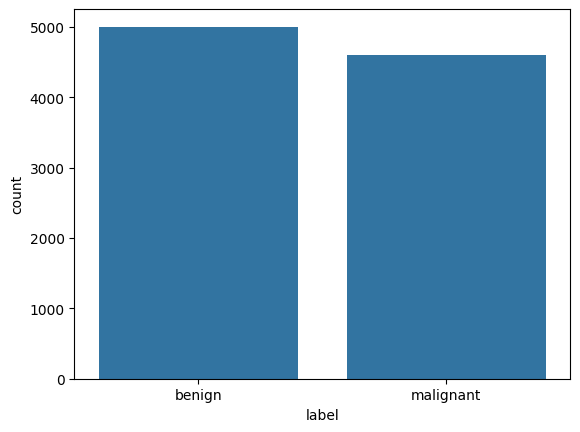

In [ ]:
import pandas as pd
import seaborn as sns
import os

# Create lists to store file names and corresponding labels
file_names = []
labels = []

# Add benign training images
benign_images = os.listdir(benign_train_dir)
file_names.extend(benign_images)
labels.extend(['benign'] * len(benign_images))

# Add malignant training images
malignant_images = os.listdir(malignant_train_dir)
file_names.extend(malignant_images)
labels.extend(['malignant'] * len(malignant_images))

# Create a DataFrame
train_data = pd.DataFrame({
    'file_name': file_names,
    'label': labels
})

# Plot the counts of each class
sns.countplot(x='label', data=train_data)


Image Generator -(Pre-Processing) or argumentation

In [ ]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

print(train_image_generator)

In [ ]:
validation_image_generator=ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=64,
    directory=train_dir,
    shuffle=True,
    target_size=(128, 128),
    class_mode='binary',
    color_mode='rgb'
)

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=64,
    directory=validation_dir,
    target_size=(128, 128),
    class_mode='binary',
    color_mode='rgb'
)


Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
def classLabel(source=None):
        datagen = ImageDataGenerator(rescale=1. / 255)
        data_generator = datagen.flow_from_directory(source,class_mode='categorical')
        class_dictionary = data_generator.class_indices
        return data_generator, class_dictionary

labels = classLabel(train_dir)
print(labels)

Found 9605 images belonging to 2 classes.
(<keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7e59042aafe0>, {'benign': 0, 'malignant': 1})


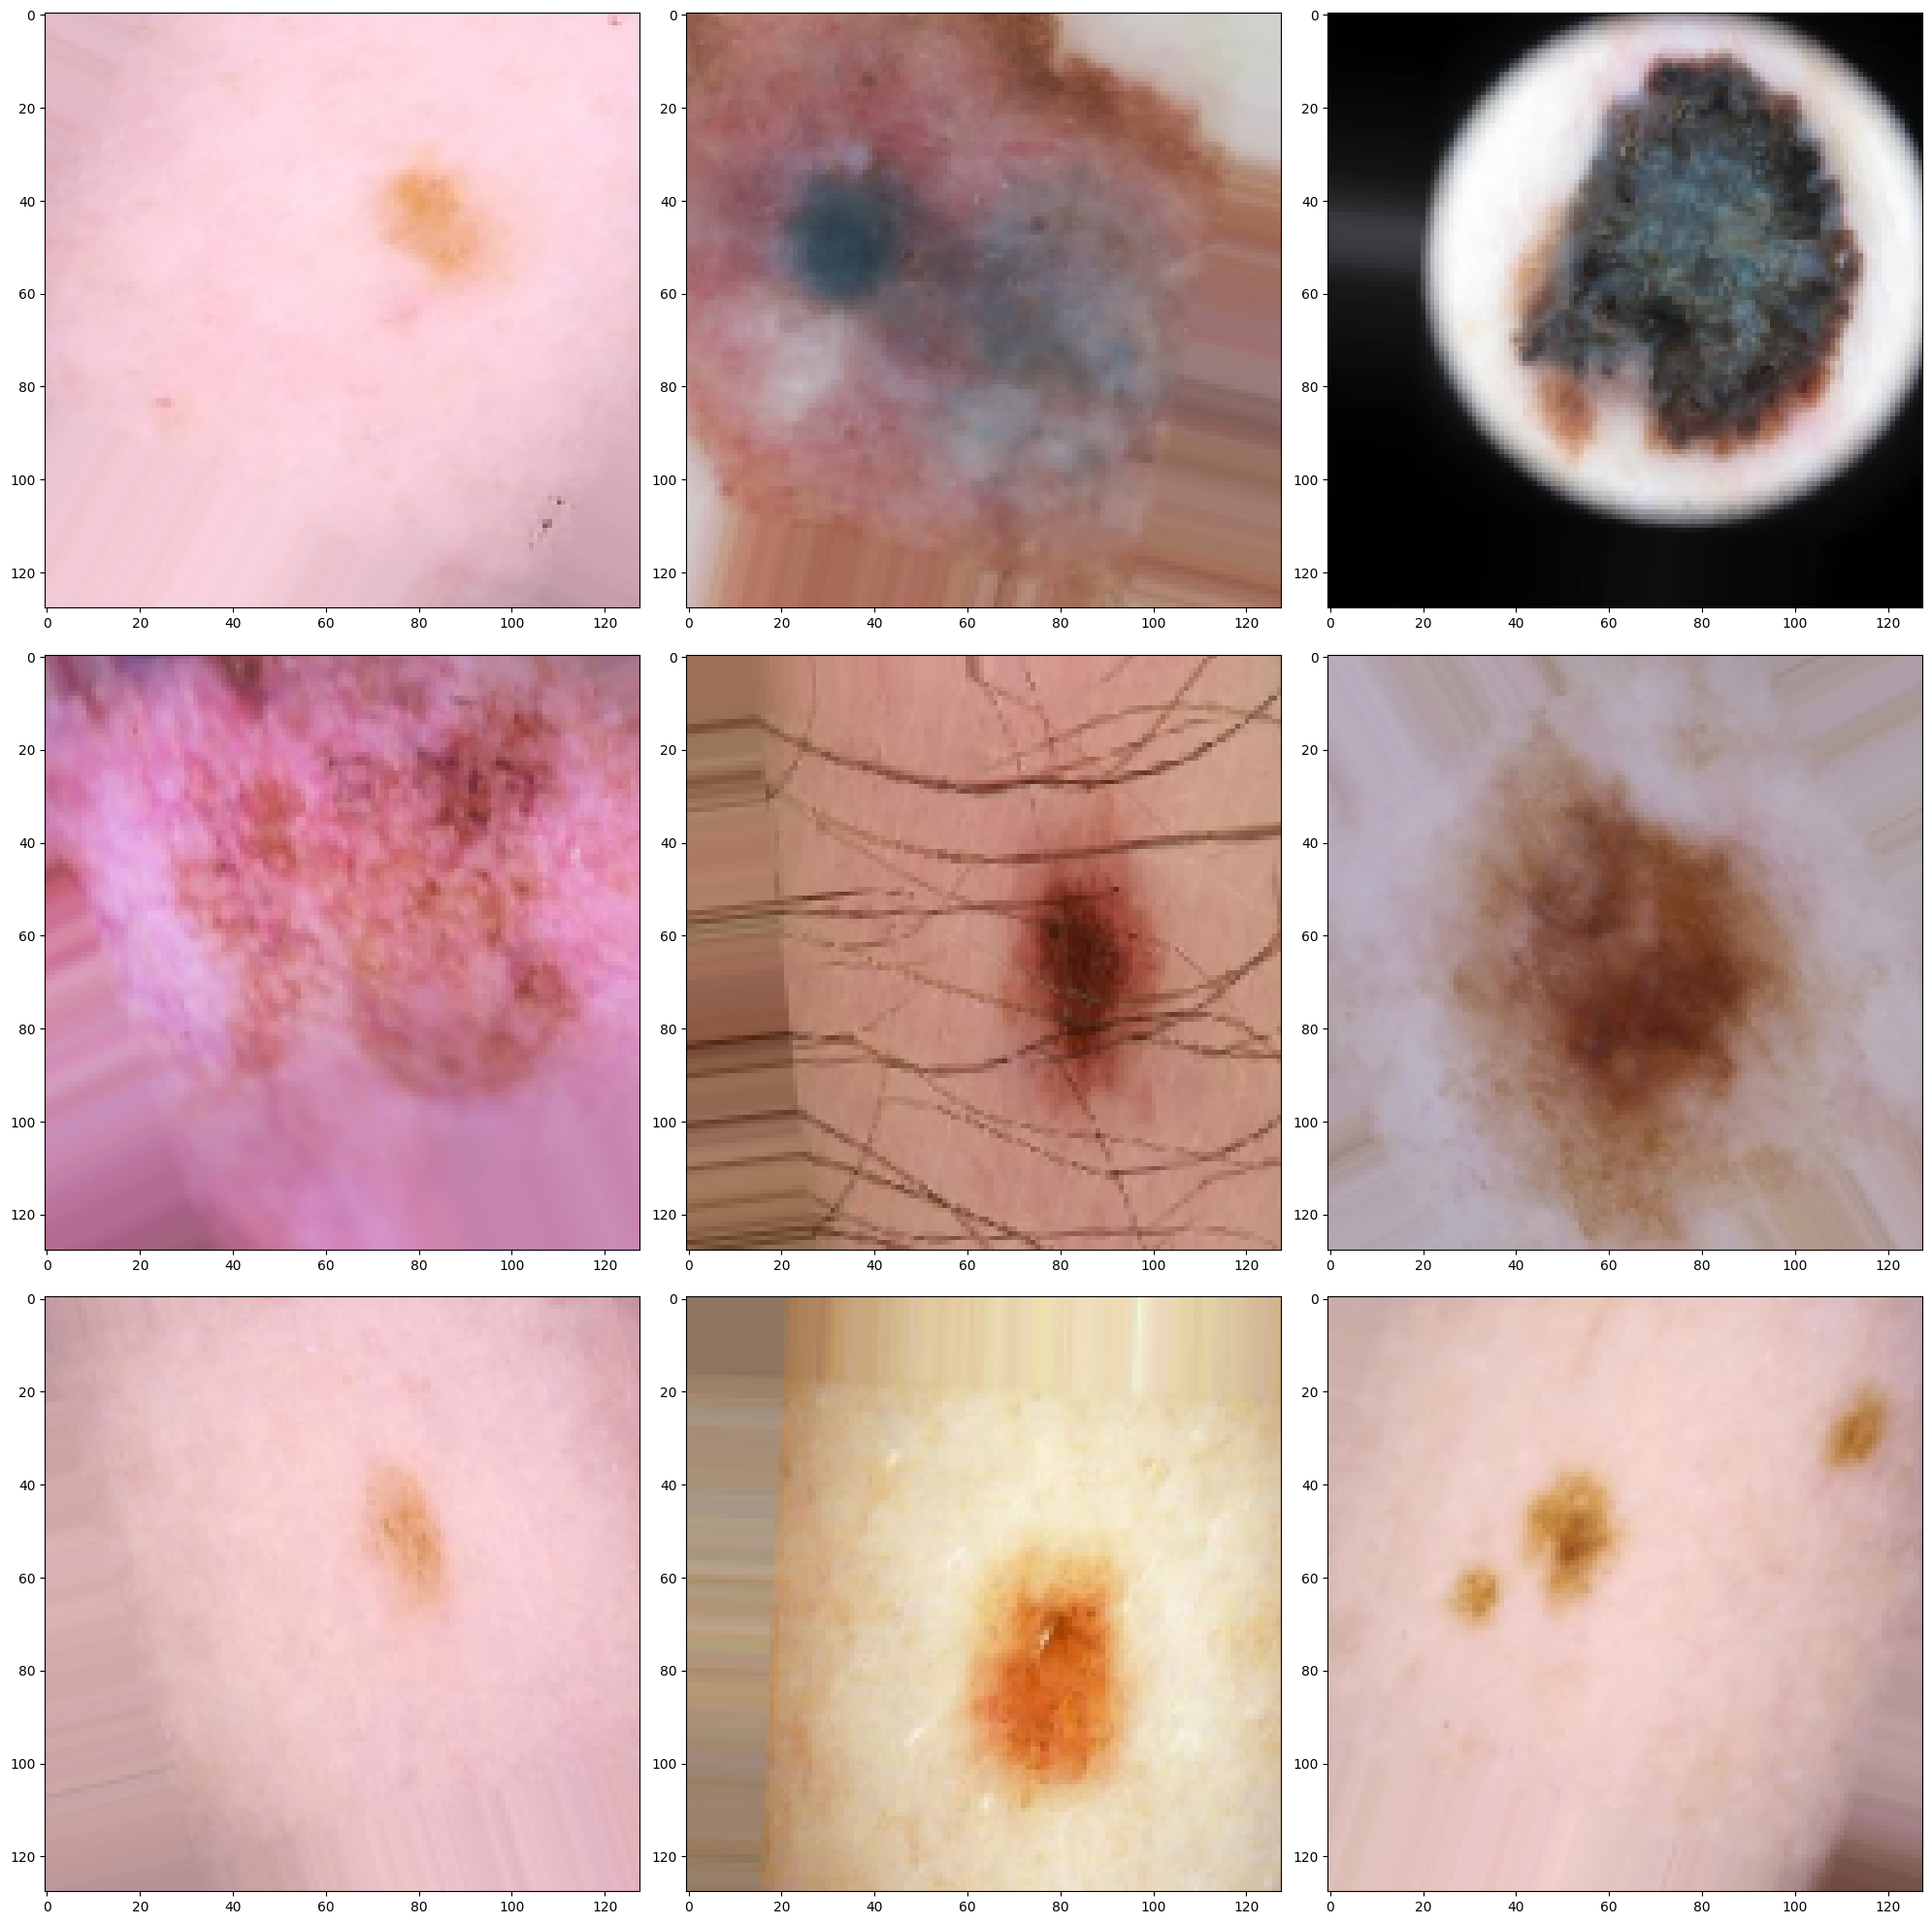

In [ ]:
sample_training_images,_ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(3,3,figsize=(20,20))
    axes = axes.flatten()
    for img , ax in zip (images_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:9])

<Axes: ylabel='count'>

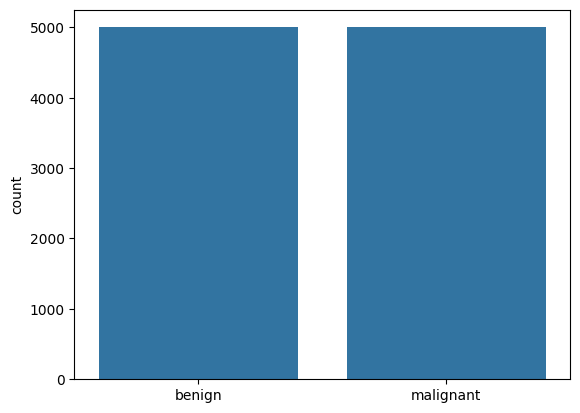

In [ ]:
import os
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Assuming x_train consists of image paths and y_train are the corresponding labels
# Prepare lists for image paths (x_train) and labels (y_train)
image_paths = []
labels = []

# Load benign training images and add to the lists
benign_images = os.listdir(benign_train_dir)
image_paths.extend([os.path.join(benign_train_dir, img) for img in benign_images])
labels.extend(['benign'] * len(benign_images))

# Load malignant training images and add to the lists
malignant_images = os.listdir(malignant_train_dir)
image_paths.extend([os.path.join(malignant_train_dir, img) for img in malignant_images])
labels.extend(['malignant'] * len(malignant_images))

# Convert lists into a DataFrame
train_data = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Separate image paths (x_train) and labels (y_train)
x_train = train_data['image_path'].values.reshape(-1, 1)
y_train = train_data['label'].values

# Initialize RandomOverSampler to balance the dataset
oversample = RandomOverSampler()

# Apply the oversampler
x_train_resampled, y_train_resampled = oversample.fit_resample(x_train, y_train)

# Visualize the balanced label distribution
sns.countplot(x=y_train_resampled)


Model Training

In [ ]:
from keras import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input

# Initialize the Sequential model
model = Sequential()

# First convolutional block
model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

# Second convolutional block
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

# Third convolutional block
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))


model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))


# Final layers
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,885,217 (64.41 MB)

 Trainable params: 16,885,185 (64.41 MB)

 Non-trainable params: 32 (128.00 B)

None


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from datetime import datetime


callbacks = [
    ModelCheckpoint("model_checkpoint.keras", save_best_only=True),
    EarlyStopping(patience=5, restore_best_weights=True)
]

steps_per_epoch = (num_benign_train + num_malignant_train) // 64
validation_steps = (num_benign_val + num_malignant_val) // 64


start_time = datetime.now()

history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=callbacks
)

end_time = datetime.now()

print('Duration: {}'.format(end_time - start_time))

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 362ms/step - accuracy: 0.7618 - loss: 0.6035 - val_accuracy: 0.7385 - val_loss: 0.5408
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8750 - loss: 0.3039 - val_accuracy: 0.7750 - val_loss: 0.5494
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 331ms/step - accuracy: 0.8606 - loss: 0.3412 - val_accuracy: 0.7990 - val_loss: 0.4543
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 127us/step - accuracy: 0.9375 - loss: 0.2766 - val_accuracy: 0.7750 - val_loss: 0.4974
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 79s 313ms/step - accuracy: 0.8655 - loss: 0.3330 - val_accuracy: 0.8135 - val_loss: 0.3738
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 133us/step - accuracy: 0.8906 - loss: 0.2745 - val_accuracy: 0.8250 - val_loss: 0.4443
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 83s 323ms/step - accuracy: 0.8703 - loss: 0.3091 - val_accuracy: 0.7969 - val_loss: 0.4634
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8906 - loss: 0.2494 - 

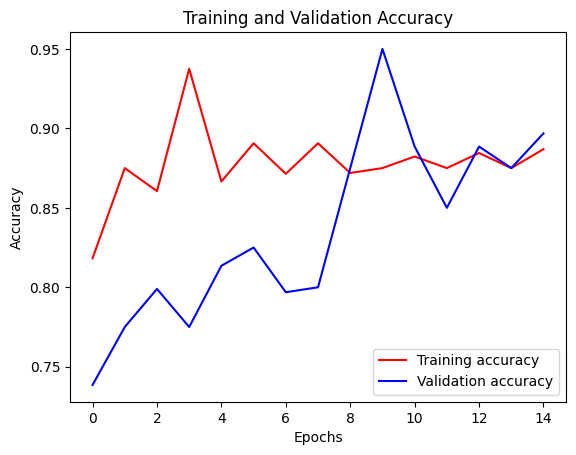

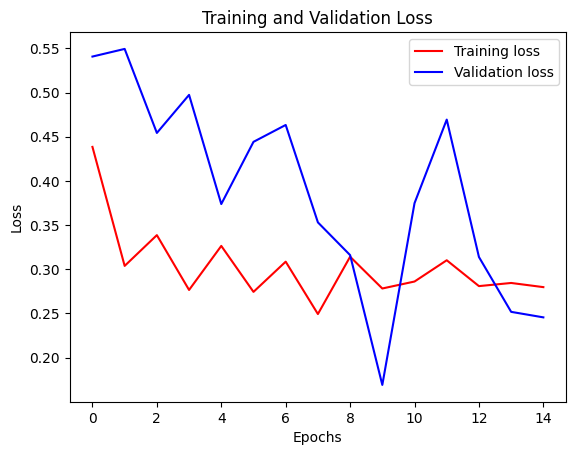

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Plot training & validation accuracy
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(val_data_gen)
predicted_classes = (predictions > 0.5).astype("int32")
true_classes = val_data_gen.classes
cm = tf.math.confusion_matrix(true_classes, predicted_classes)
print(cm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
tf.Tensor(
[[275 225]
 [273 227]], shape=(2, 2), dtype=int32)


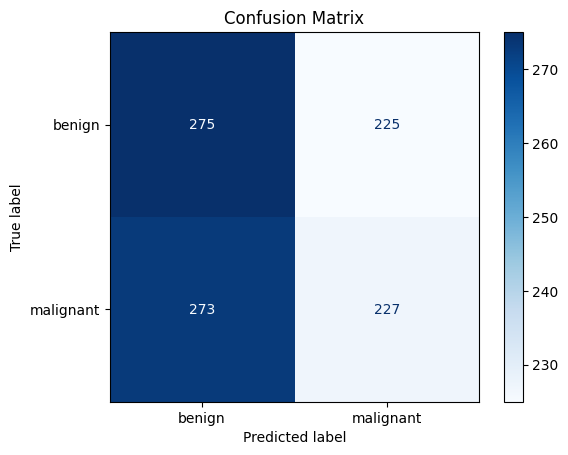

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm.numpy(), display_labels=["benign", "malignant"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def load_and_preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array



In [ ]:
def predict_image_class(img_path, model, data_gen):
    processed_image = load_and_preprocess_image(img_path)
    predictions = model.predict(processed_image)
    predicted_class = np.argmax(predictions, axis=1)
    class_labels = {v: k for k, v in data_gen.class_indices.items()}
    predicted_class_label = class_labels[predicted_class[0]]
    return predicted_class_label


In [ ]:
current = os.getcwd()
img_dir = os.path.join(current,'photos')
sample_image_path = img_dir+'\OIP.jpeg'

print(os.path.isfile(sample_image_path))

# Predict the class
predicted_label = predict_image_class(sample_image_path, model, train_data_gen)
print(f'The predicted class for the sample image is: {predicted_label}')

